<a href="https://colab.research.google.com/github/tzupingchenwork/Angular30daysMyTodoList/blob/master/%E5%8F%B0%E8%82%A1%E7%A0%94%E7%A9%B6%E5%AE%A4%E5%AF%A6%E4%BD%9C_%E5%96%AE%E5%9B%A0%E5%AD%90%E9%81%B8%E8%82%A1(Beta).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install

實作部落格說明：
https://reurl.cc/E2x1jk

In [ ]:
!pip install git+https://github.com/finlab-python/finlab.git


  Cloning https://github.com/finlab-python/finlab.git to /tmp/pip-req-build-prxmy6zb
  Running command git clone -q https://github.com/finlab-python/finlab.git /tmp/pip-req-build-prxmy6zb
  Created wheel for finlab: filename=finlab-0.1.11.dev1-cp37-none-any.whl size=38739 sha256=79e55e266f8218b65673a1a03a5414c780302f67a5452959581e8b29d454bd13
  Stored in directory: /tmp/pip-ephem-wheel-cache-1xftcwfq/wheels/66/66/b8/7fedb3c1cd19acc4a7c460bf1818edfeafc574ca3caed4a4c0
Successfully built finlab


In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime,date
import finlab
from finlab import data
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
from scipy import stats
import seaborn as sns

In [ ]:
finlab.set_token('vPrVSU1klPn98i5OBK3HQRjQBhR9odXvB6dqSOsU/GvjjkNSgQ2Q0vr7Y/kSI8Wa')

## Caculate Beta & Alpha

meaning:https://reurl.cc/zb3rdV

reference:https://www.codingfinance.com/post/2018-04-25-portfolio-beta-py/

### Check Portfolio Beta & Alpha

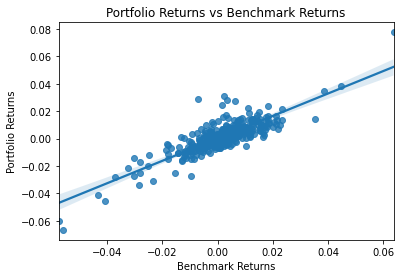

(0.8195741633616181, 0.0001643545567310467)

In [ ]:
tickers = ['1101', '2330', '6261', '6263', '9939']
weights = [0.1,0.2,0.25,0.25,0.2]


def get_alpha_beta(tickers:list,weights:list,start_date=None,end_date=None,limit=None,price_data=None,benchmark_ret=None,plot=False):
    if price_data is None:
        price_data =data.get_adj()
    price_data = price_data[tickers]
    if start_date:
        price_data = price_data[price_data.index >= start_date]
    if end_date:
        price_data = price_data[price_data.index <= end_date]
    if limit:
        price_data = price_data.iloc[-limit:]
    ret_data = price_data.replace(0,np.nan).fillna(method='ffill').pct_change()[1:]
    port_ret = (ret_data * weights).sum(axis = 1)
    if benchmark_ret is None:
        benchmark_ret=data.get('benchmark_return:發行量加權股價報酬指數').pct_change()[1:].loc[port_ret.index].iloc[:,-1]
    if plot:
        df=pd.concat([benchmark_ret, port_ret], axis=1)
        df.columns=['benchmark','port']
        sns.regplot(x='benchmark',y='port',data=df)
        plt.xlabel("Benchmark Returns")
        plt.ylabel("Portfolio Returns")
        plt.title("Portfolio Returns vs Benchmark Returns")
        plt.show()
    beta, alpha = stats.linregress(benchmark_ret.values,port_ret.values)[:2]
    return beta, alpha

get_alpha_beta(tickers,weights,'2020-1-1','2021-4-30',plot=True)

### Beta Strategy

#### add_profit_prediction

In [ ]:
def add_profit_prediction(dataset,price_option='收盤價', n=1):
    
    dates = sorted(list(set(dataset.reset_index()['date'])))
    adj_price = data.get_adj(price_option).replace(0,np.nan).fillna(method='ffill')
    tomorrow_adj_price = adj_price.shift(-1)
    tomorrow_adj_price = tomorrow_adj_price.reindex(dates, method='bfill')
    p = (tomorrow_adj_price.shift(-n) / tomorrow_adj_price)
    dataset['return'] = p.unstack()

#### backtest

選股與回測條件：

1.   beta以進場日前200天計算。
2.   每回合持有一季，不帶入稅費計算，主要看分組趨勢。
3.   參考台股研究室，beta分10組，第1組為beta最小前10%，第10組為beta最大前10%，由小大大，以此類推。分組回測主要是方便觀察單因子是否為單調線性，若是，策略效果較顯著，若為曲折線型，則參考度較小。



程式細節：

使用pandas的rank與cut分組

https://pandas.pydata.org/docs/reference/api/pandas.cut.html

In [ ]:
beta_cal_range=200
now = datetime.now().strftime("%Y-%m-%d")
dates=pd.date_range(start='2008-1-1', end=now , freq='3MS')

df_set=[]
for date in dates:
    print(f'process {date}')
    price_data =data.get_adj()
    port_ret = price_data[price_data.index < date].replace(0,np.nan).fillna(method='ffill').pct_change()[1:].iloc[-beta_cal_range:].dropna(axis=1)
    benchmark_ret=data.get('benchmark_return:發行量加權股價報酬指數').pct_change()[1:].loc[port_ret.index].iloc[:,-1]
    df=pd.DataFrame([{'stock_id':i,'beta':stats.linregress(benchmark_ret.values,port_ret[i])[0] } for i in port_ret.columns])
    df['date']=date
    df['beta_rank']=df['beta'].rank(pct=True)
    labels=[str(i) for i in range(10,0,-1)]
    df['label']=pd.cut(df['beta_rank'],bins=[i/10 for i in range(0,11,1)], labels=labels)
    df_set.append(df)

df_all=pd.concat(df_set)
df_all

process 2008-01-01 00:00:00
process 2008-04-01 00:00:00
process 2008-07-01 00:00:00
process 2008-10-01 00:00:00
process 2009-01-01 00:00:00
process 2009-04-01 00:00:00
process 2009-07-01 00:00:00
process 2009-10-01 00:00:00
process 2010-01-01 00:00:00
process 2010-04-01 00:00:00
process 2010-07-01 00:00:00
process 2010-10-01 00:00:00
process 2011-01-01 00:00:00
process 2011-04-01 00:00:00
process 2011-07-01 00:00:00
process 2011-10-01 00:00:00
process 2012-01-01 00:00:00
process 2012-04-01 00:00:00
process 2012-07-01 00:00:00
process 2012-10-01 00:00:00
process 2013-01-01 00:00:00
process 2013-04-01 00:00:00
process 2013-07-01 00:00:00
process 2013-10-01 00:00:00
process 2014-01-01 00:00:00
process 2014-04-01 00:00:00
process 2014-07-01 00:00:00
process 2014-10-01 00:00:00
process 2015-01-01 00:00:00
process 2015-04-01 00:00:00
process 2015-07-01 00:00:00
process 2015-10-01 00:00:00
process 2016-01-01 00:00:00
process 2016-04-01 00:00:00
process 2016-07-01 00:00:00
process 2016-10-01 0

,stock_id,beta,date,beta_rank,label
0,0015,0.850880,2008-01-01,0.515353,5
1,0050,0.954369,2008-01-01,0.658091,4
2,0051,0.955610,2008-01-01,0.659751,4
3,0052,0.759476,2008-01-01,0.384232,7
4,1101,1.254223,2008-01-01,0.952697,1
...,...,...,...,...,...
1913,9951,0.661945,2021-04-01,0.761210,3
1914,9955,0.811430,2021-04-01,0.855057,2
1915,9958,0.556259,2021-04-01,0.679353,4
1916,9960,0.019799,2021-04-01,0.142336,9


In [ ]:
label_group=df_all.copy()
label_group=label_group.set_index(['stock_id','date'])
add_profit_prediction(label_group)
label_group=label_group.groupby(['date','label'])[['beta','return']].mean()
label_group=label_group.dropna()
label_group=label_group.reset_index()
label_group['cumprod_return']=label_group.groupby(['label'])[['return']].cumprod()
label_group

,date,label,beta,return,cumprod_return
0,2008-01-01,10,0.173080,1.138556,1.138556
1,2008-01-01,9,0.494327,1.077994,1.077994
2,2008-01-01,8,0.626975,1.038548,1.038548
3,2008-01-01,7,0.732246,1.064473,1.064473
4,2008-01-01,6,0.805996,1.046692,1.046692
...,...,...,...,...,...
525,2021-01-01,5,0.795014,1.119071,3.903502
526,2021-01-01,4,0.895135,1.147291,3.656729
527,2021-01-01,3,0.997832,1.144193,3.184854
528,2021-01-01,2,1.150622,1.195055,2.349033


## Plot

### Beta group scatter

In [ ]:
fig = px.bar(label_group, x="date", y="return",
             color='label', barmode='group',
             height=400,title="Beta group-return")
fig.show()


fig = px.bar(label_group, x="date", y="beta",
             color='label', barmode='group',
             height=400,title="Beta group-beta value")
fig.show()

fig = px.scatter(label_group, x="return", y="beta", color="label",
                 size='return', hover_data=['return','beta'],title="Beta group scatter-beta value v.s. return")
fig.show()

### Beta group cumprod_return

In [ ]:
fig = px.line(label_group, x="date", y="cumprod_return", color='label', title="Beta group cumprod_return")
fig.update_traces(mode="markers+lines", hovertemplate=None)

# 讓y軸hover同步
fig.update_layout(hovermode="x unified")
fig.show()

### Compare Equity Value

In [ ]:
def reindex_entry_date(date):
    if date.month==3:
        date=datetime(date.year,4,1)
    elif date.month==5:
        date=datetime(date.year,7,1)
    elif date.month==8:
        date=datetime(date.year,10,1)
    elif date.month==11:
        date=datetime(date.year+1,1,1)
    return date

equity=data.get('tw_financial_statements:股本')
equity_refactor=equity.copy()
equity_refactor.index=[reindex_entry_date(d) for d in equity_refactor.index]
equity_refactor=equity_refactor.unstack()

equity_df=df_all.copy()
equity_df=equity_df.set_index(['stock_id','date'])
equity_df['base']=equity_refactor
equity_df=equity_df.dropna()
equity_df=equity_df.groupby(['label'])[['base']].median()
equity_df=equity_df.reset_index()

In [ ]:
fig = px.bar(equity_df, x="label", y="base",
             color='label',height=400,title="Beta group-equity")
fig.show()